In [1]:
import torch
import torch.nn as nn
import torchvision
import pickle as pkl
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

**1. Завантаження та попередня обробка даних:**
  * Завантажте набір даних MNIST (він доступний як в TensorFlow, так і в PyTorch).
  * Нормалізуйте значення пікселів до діапазону [-1, 1], що покращить процес навчання GAN.

In [3]:
torch.manual_seed(42)
np.random.seed(42)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transform,
                               download=True)

batch_size = 128
dataloader = DataLoader(dataset=dataset,
                         batch_size=batch_size,
                         shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.60MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.04MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
print(f"Length dataset: {len(dataset)}")
print(f"Length dataloader: {len(dataloader)}")

Length dataset: 60000
Length dataloader: 469


In [97]:
image_batch = next(iter(dataloader))

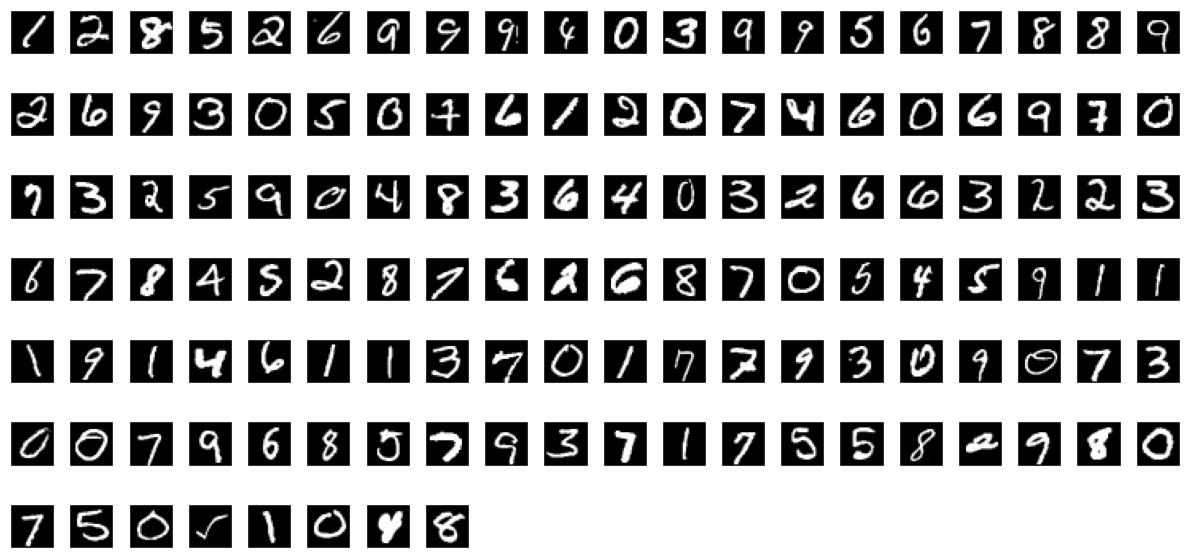

In [6]:
# #згенеровані приклади датасету
import math

def display_images(images, n_cols=20, figsize=(12, 6)):
    plt.style.use('ggplot')
    n_images = len(images)
    n_rows = math.ceil(n_images / n_cols)
    plt.figure(figsize=figsize)
    for idx in range(n_images):
        ax = plt.subplot(n_rows, n_cols, idx+1)
        image = images[idx]
        # make dims H x W x C
        image = image.permute(1, 2, 0)
        cmap = 'gray' if image.shape[2] == 1 else plt.cm.viridis
        ax.imshow(image, cmap=cmap)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

display_images(images=image_batch[0], n_cols=20)

**2. Створення архітектури генератора:**
  * Створіть генератор, який приймає випадковий шум на вході (наприклад, вектор розміром 100).
  * Генератор може складатися з декількох шарів (Dense) з функціями активації ReLU і завершуватись вихідним шаром із функцією активації tanh, щоб генерувати зображення розміром 28x28.

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1, 28, 28)

**3. Створення архітектури дискримінатора:**
  * Створіть дискримінатор, який приймає зображення розміром 28x28 як вхід.
  * Дискримінатор може складатися з декількох повнозв’язних шарів (Dense) з функціями активації LeakyReLU.
  * Останній шар має мати один вихід із функцією активації sigmoid для визначення, чи є зображення реальним чи згенерованим.

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
      x = x.view(-1,784)
      return self.model(x)

In [9]:
# Initialize the generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [10]:
criterion = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0002)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

In [11]:
num_epochs = 50

z_size = 100
fixed_z = np.random.uniform(-1, 1, size=(16, z_size))
fixed_z = torch.from_numpy(fixed_z).float().to(device)
fixed_samples = []
d_losses = []
g_losses = []

#Тренування

for epoch in range(num_epochs):
  for i, (real_images, _) in enumerate(dataloader):
    batch_size = real_images.size(0)
    real_images = real_images.to(device)

    #Навчання дискримінатора
    discriminator.zero_grad()
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    outputs_real = discriminator(real_images)
    loss_real = criterion(outputs_real, real_labels)

    noise = torch.randn(batch_size, 100).to(device)
    fake_images = generator(noise)
    outputs_fake = discriminator(fake_images.detach())
    loss_fake = criterion(outputs_fake, fake_labels)

    loss_d = loss_real + loss_fake
    loss_d.backward()
    optimizer_d.step()

    #Навчання генератора
    generator.zero_grad()
    noise = torch.randn(batch_size, 100).to(device)
    fake_images = generator(noise)
    outputs = discriminator(fake_images)
    loss_g = criterion(outputs, real_labels)
    loss_g.backward()
    optimizer_g.step()

  # Логування втрат
  d_epoch_loss = loss_d.item()
  g_epoch_loss = loss_g.item()
  d_losses.append(d_epoch_loss)
  g_losses.append(g_epoch_loss)

  print(f'epoch [{epoch + 1}/{num_epochs}], epoch_d_loss: {d_epoch_loss:.4f} \tepoch_g_loss: {g_epoch_loss:.4f}')

  # Навчаємо модель та вносимо результати для перевірки після n epoch
  generator.eval()
  fixed_samples.append(generator(fixed_z).detach().cpu())

#Записуємо результати для перевірки після n epoch
with open('fixed_samples.pkl', 'wb') as f:
  pkl.dump(fixed_samples, f)


epoch [1/50], epoch_d_loss: 0.0645 	epoch_g_loss: 11.4281
epoch [2/50], epoch_d_loss: 0.2046 	epoch_g_loss: 10.0620
epoch [3/50], epoch_d_loss: 1.4575 	epoch_g_loss: 1.1086
epoch [4/50], epoch_d_loss: 0.0961 	epoch_g_loss: 4.0104
epoch [5/50], epoch_d_loss: 0.1547 	epoch_g_loss: 5.7499
epoch [6/50], epoch_d_loss: 0.3191 	epoch_g_loss: 4.6065
epoch [7/50], epoch_d_loss: 0.0782 	epoch_g_loss: 4.8983
epoch [8/50], epoch_d_loss: 0.3162 	epoch_g_loss: 3.9016
epoch [9/50], epoch_d_loss: 0.2817 	epoch_g_loss: 3.2818
epoch [10/50], epoch_d_loss: 0.1639 	epoch_g_loss: 5.5223
epoch [11/50], epoch_d_loss: 0.3134 	epoch_g_loss: 4.1565
epoch [12/50], epoch_d_loss: 0.3951 	epoch_g_loss: 4.3591
epoch [13/50], epoch_d_loss: 0.2447 	epoch_g_loss: 3.7237
epoch [14/50], epoch_d_loss: 0.3797 	epoch_g_loss: 4.2739
epoch [15/50], epoch_d_loss: 0.3446 	epoch_g_loss: 4.1833
epoch [16/50], epoch_d_loss: 0.4272 	epoch_g_loss: 3.5509
epoch [17/50], epoch_d_loss: 0.3232 	epoch_g_loss: 3.4069
epoch [18/50], epoch_

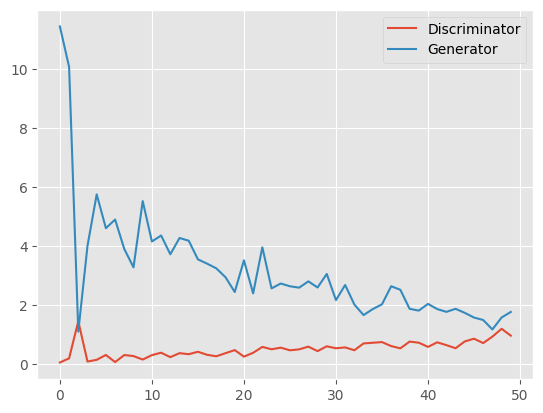

In [12]:
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

In [16]:
def show_generated_images(epoch, n_cols=8):
    # load saved images
    with open('fixed_samples.pkl', 'rb') as f:
        saved_data = pkl.load(f)
    epoch_data = saved_data[epoch-1]
    # re-scale back to 0-1
    epoch_data = (epoch_data + 1) / 2
    # re-shape to (batch_size, channel, height, width)
    batch_size, channel, height, width = len(epoch_data), 1, 28, 28
    image_batch = epoch_data.view(batch_size, channel, height, width)
    display_images(images=image_batch, n_cols=n_cols, figsize=(12, 4))

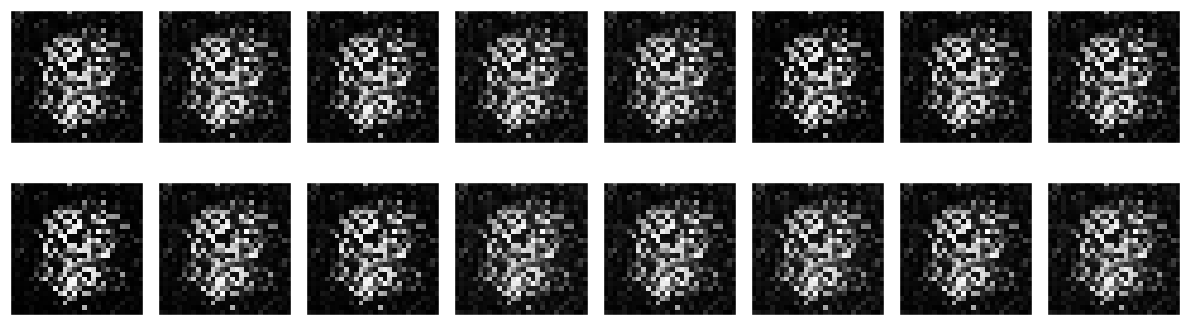

In [17]:
#Результат після 1 епохи
show_generated_images(epoch = 1, n_cols = 8)

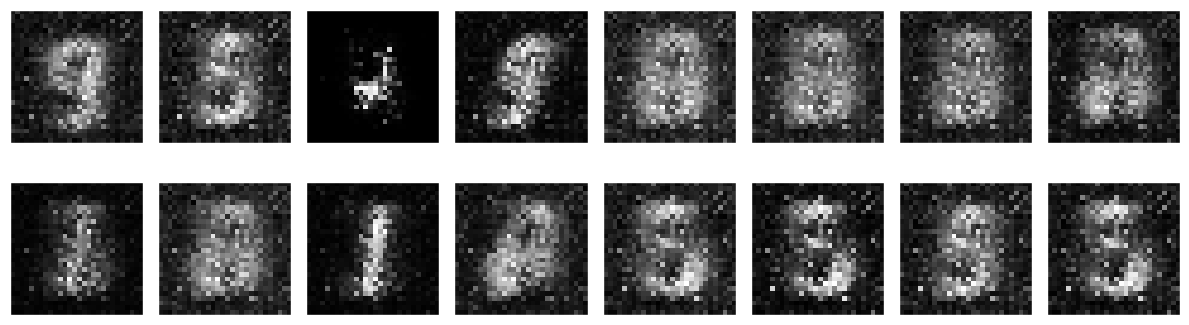

In [18]:
#Результат після 10 епохи
show_generated_images(epoch = 10, n_cols = 8)

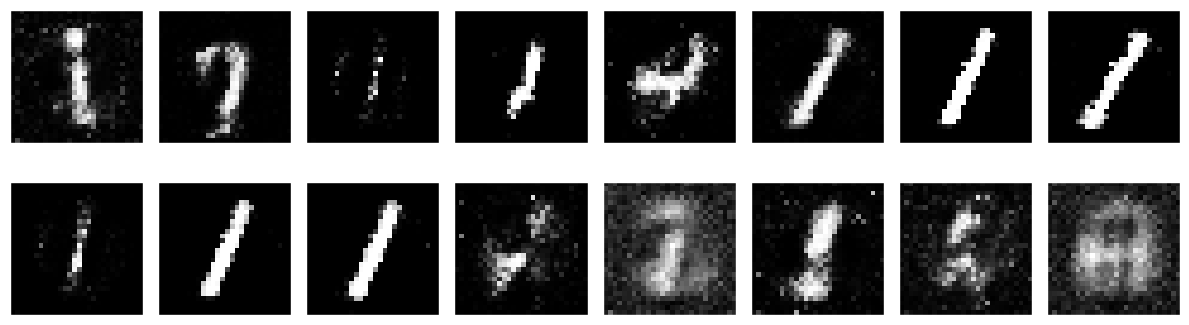

In [19]:
#Результат після 20 епохи
show_generated_images(epoch = 20, n_cols = 8)

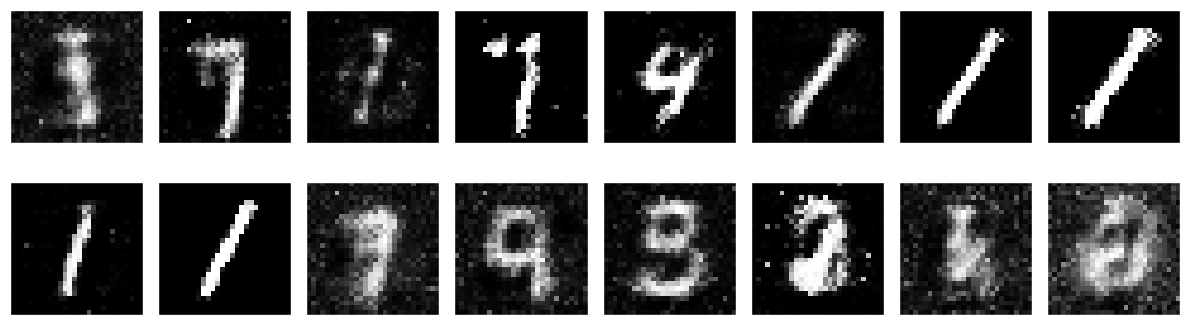

In [20]:
#Результат після 30 епохи
show_generated_images(epoch = 30, n_cols = 8)

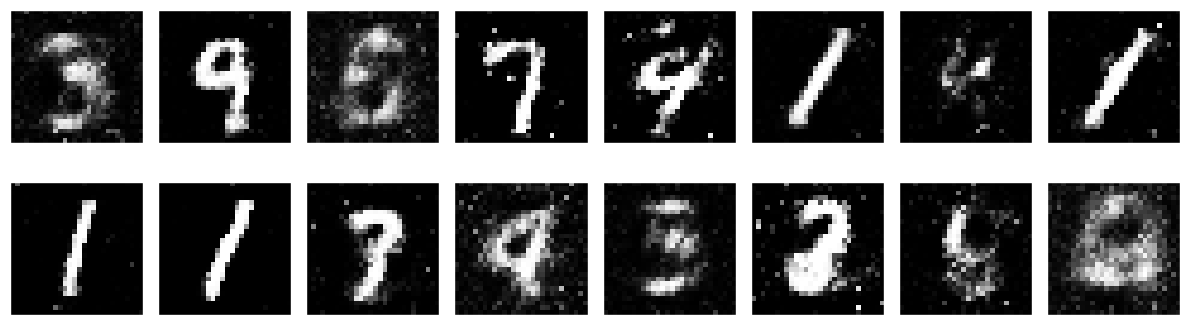

In [21]:
#Результат після 40 епохи
show_generated_images(epoch = 40, n_cols = 8)

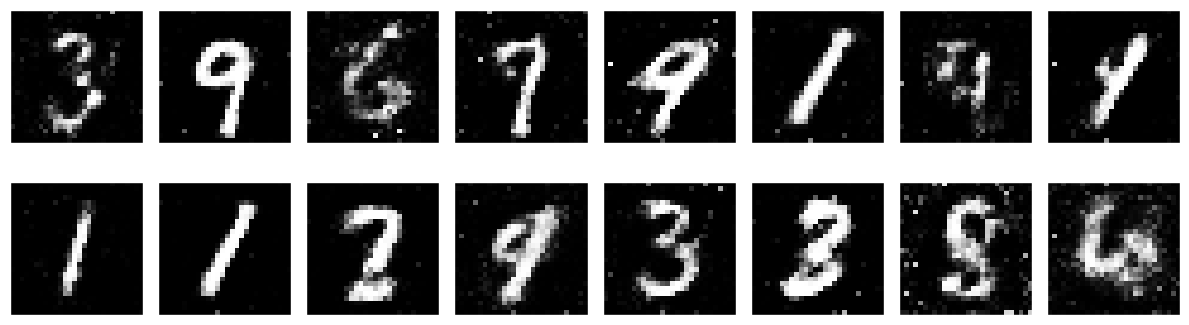

In [22]:
#Результат після 50 епохи
show_generated_images(epoch = 50, n_cols = 8)